In [1]:
import cv2
import imutils
import numpy as np

from profile import profile
from spimage import *
from sphomography import *
from spvoronoi import *

# import images, compute homographies

In [7]:
establishing_array = cv2.imread('conc/2016-04-05 11.07.33.jpg')
close_arrays = map(cv2.imread, [
    'conc/2016-04-05 11.07.44.jpg',
    'conc/2016-04-05 11.07.50.jpg',
    'conc/2016-04-05 11.07.56.jpg',
    'conc/2016-04-05 11.08.01.jpg'
])
establishing = Image.from_array(establishing_array)
closes = map(Image.from_array, close_arrays)

# establishing = establishing.resize(establishing.width / 2)
# closes = map(lambda x: x.resize(x.width / 2), closes)

In [4]:
establishing_array = cv2.imread('establishing.jpg')
close_arrays = map(cv2.imread, [
    '2016-03-14 17.46.19.jpg', '2016-03-14 17.46.43.jpg', '2016-03-14 17.47.18.jpg',
    '2016-03-14 17.47.22.jpg', '2016-03-14 17.47.26.jpg', '2016-03-14 17.47.30.jpg',
    '2016-03-14 17.47.34.jpg', '2016-03-14 17.47.38.jpg', '2016-03-14 17.47.42.jpg',
    '2016-03-14 17.47.50.jpg', '2016-03-14 17.47.53.jpg', '2016-03-14 17.47.57.jpg',
    '2016-03-14 17.48.04.jpg', '2016-03-14 17.48.08.jpg', '2016-03-14 17.48.11.jpg',
    '2016-03-14 17.48.15.jpg', '2016-03-14 17.48.19.jpg'])

establishing = Image.from_array(establishing_array)
closes = map(Image.from_array, close_arrays)

In [9]:
import multiprocessing.dummy

pool = multiprocessing.dummy.Pool()

with profile('hom.prof'):
    e_features = find_features(establishing)
    cs_features = pool.map(lambda c: find_features(c.resize(1200)), closes)
    hs = pool.map(lambda c_features: find_homography(c_features, e_features), cs_features)

7.69699311256 seconds


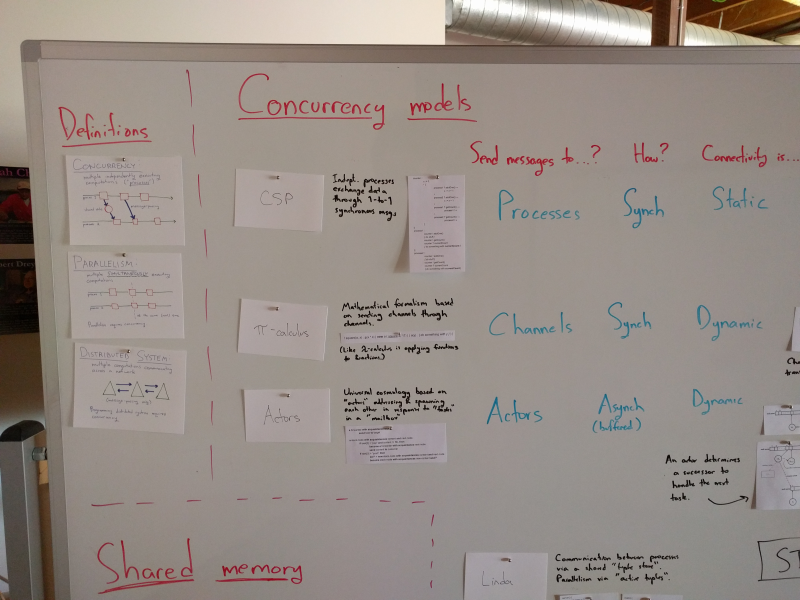

2016-04-06T22_31_24.579049.png

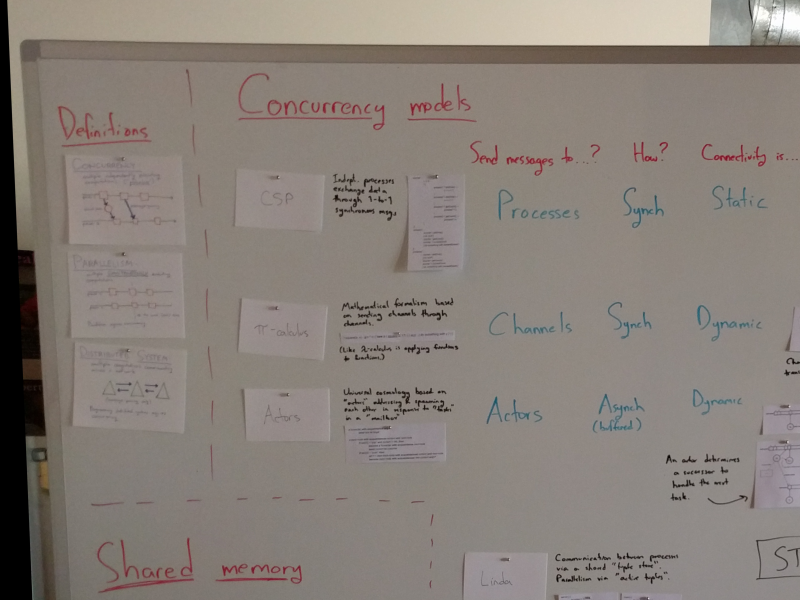

2016-04-06T22_31_25.256908.png

In [12]:
d, _ = apply_homography(establishing, hs[0].invert(), closes[0].system, closes[0].dims)

closes[0].show()
d.show()

# play with color adjustment

In [13]:
def find_white(array):
    pixels = array.reshape((-1, 3))
    grey = cv2.cvtColor(array, cv2.COLOR_BGR2GRAY).reshape(-1)
    gsort = grey.argsort()
    top_5_percent = gsort[-len(gsort)/20:]
    return pixels[top_5_percent].mean(axis=0)

def white_balance(image):
    to_return = image.pipe(lambda a: a / find_white(a.astype(np.uint8)) * [255, 255, 255])
    return to_return

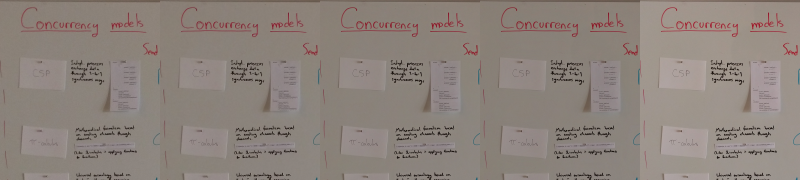

2016-04-06T22_31_29.465509.png

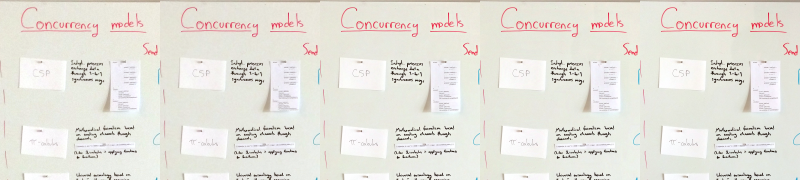

2016-04-06T22_31_34.299789.png

In [14]:
f = closes[0][1000:-1500, 300:-1000]
a = d[1000:-1500, 300:-1000]

def test(size):
    # g = f.pipe(cv2.bilateralFilter, 30, 300, 2)
#     g = f.pipe(cv2.medianBlur, size)
    g = f.pipe(cv2.GaussianBlur, (2 * size + 1, 2 * size + 1), size)

    detail = operate(
        lambda num, denom: num / denom, 
        f.astype(float).pipe(lambda a: a + 4),
        g.astype(float).pipe(lambda a: a + 4)
    )

    # b = a.pipe(cv2.bilateralFilter, 30, 300, 2)
#     b = a.pipe(cv2.medianBlur, size)
    b = a.pipe(cv2.GaussianBlur, (2 * size + 1, 2 * size + 1), size)


    final = operate(
        lambda b, detail: b * detail,
        b, detail
    )

    return final

reduce(abut, [i for i in [a, test(5), test(33), test(99), f]]).show()

reduce(abut, [white_balance(i).normalize() for i in [a, test(5), test(33), test(99), f]]).show()

# voronoi fun

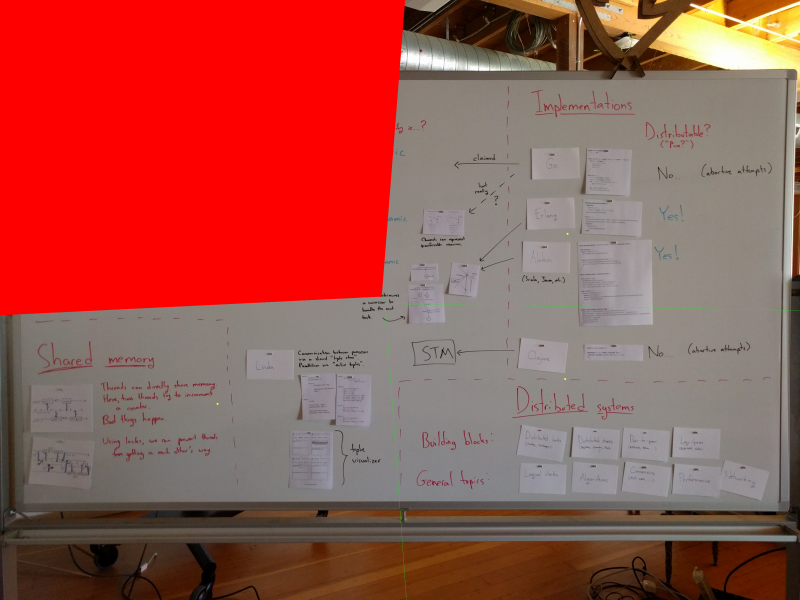

2016-04-06T22_31_35.542958.png

In [15]:
from spvoronoi import voronoi, clip

# diagram = establishing.resize(800)
diagram = establishing.copy()
for i, close in enumerate(closes):
    diagram.draw_circle(hs[i](close.center()), radius=5, inplace=True)

centers = [hs[i](closes[i].center()) for i in range(len(hs))]
facets = voronoi(centers, establishing.system, establishing.dims)

# facets

for facet in facets:
    diagram.draw_polyline(facet, inplace=True)
diagram.fill_poly(facets[0], (0, 0, 255), inplace=True)
diagram.show()


## simple stitch

In [ ]:
canvas = establishing.resize(establishing.width * 2)

# for i in [0, 2]:
for i in range(len(closes)):
    foreground, mask = apply_homography(closes[i], hs[i], canvas.system, canvas.dims)
    voronoi_mask = (
        canvas.pipe(np.zeros_like)
        .fill_poly(clip(facets[i], canvas.corners()), color=(1, 0, 0))
        .pipe(lambda x: x[:, :, 0])
    )
    combo_mask = operate(lambda x, y: x * y, mask, voronoi_mask)
    composite(canvas, foreground, combo_mask, inplace=True)

canvas.show()

In [ ]:
# white balance it!

canvas = establishing.resize(establishing.width * 2)

# for i in [0, 2]:
for i in range(len(closes)):
    foreground, mask = apply_homography(white_balance(closes[i]).normalize(), hs[i], canvas.system, canvas.dims)
    voronoi_mask = (
        canvas.pipe(np.zeros_like)
        .fill_poly(clip(facets[i], canvas.corners()), color=(1, 0, 0))
        .pipe(lambda x: x[:, :, 0])
    )
    combo_mask = operate(lambda x, y: x * y, mask, voronoi_mask)
    composite(canvas, foreground, combo_mask, inplace=True)

canvas.show()

In [ ]:
np.expand_dims()

In [16]:
from numba import jit
import numpy as np

@jit(nopython=True)
def sum_arrs(arrs):
    base = np.zeros(arrs[0].shape)
    for arr in arrs:
        base += arr
    return base

'''Must receive no NaNs! That's what masks are for.'''
@jit
def composite_arrs(arrs, masks):
    mask_sum = sum_arrs(masks)
    
    base = np.zeros(arrs[0].shape)
    for arr, mask in zip(arrs, masks):
        base += arr * np.expand_dims(np.true_divide(mask, mask_sum), 2)
    return base

def cont_composite(images, masks):
    system = images[0].system
    assert all(image.system == system for image in images)
    assert all(mask.system == system for mask in masks)

    arr = composite_arrs(tuple(np.nan_to_num(image.array).astype(np.float64) for image in images),
                         tuple(np.nan_to_num(mask.array).astype(np.float64) for mask in masks))
    
    return Image(arr, system)

In [ ]:
# detail-transfer and blur it!

import time

from numba import jit

@jit
def stable_divide(num, denom):
    return (num + 4.) / (denom + 4)

def blur_with_mask(image, mask, size):
    image_blurred = image.astype(float).pipe(cv2.blur, (2 * size + 1, 2 * size + 1))
    mask_blurred = mask.pipe(cv2.blur, (2 * size + 1, 2 * size + 1))
#     print image_blurred.array.dtype, image_blurred.array.shape, mask_blurred.array.dtype, mask_blurred.array.shape
    image_blurred.array /= mask_blurred.array[:, :, np.newaxis]
    return image_blurred

def detail_transfer(background, foreground, size=33, background_blurred=None, mask=None):
    foreground_blurred = blur_with_mask(foreground, mask, size)

    detail_array = stable_divide(foreground.array, foreground_blurred.array)
    if mask is not None:
        detail_array *= mask.array[:, :, np.newaxis]

    if background_blurred is None:
        background_blurred = background.pipe(cv2.blur, (2 * size + 1, 2 * size + 1), size)

    return operate(
        lambda a: a * detail_array,
        background_blurred
    )

edge_blur = 33
detail_blur = 33
canvas = white_balance(establishing).normalize().resize(establishing.width * 3)
canvas_blurred = canvas.pipe(cv2.blur, (2 * detail_blur + 1, 2 * detail_blur + 1))

todo = range(len(closes))

last = None

@jit
def complete_voronoi_mask(voronoi_mask_arr, homography_mask_arr):
    return (voronoi_mask_arr[:, :, 0] / 255) * homography_mask_arr

def process_i(i):
    foreground, homography_mask = apply_homography(
        white_balance(closes[i]).normalize(), hs[i], canvas.system, canvas.dims, erode=1)
    combo_mask = (
        canvas.pipe(np.zeros_like, dtype=float)
        .fill_poly(clip(facets[i], canvas.corners()), color=(255, 0, 0), inplace=True)
        .pipe(cv2.blur, (2 * edge_blur + 1, 2 * edge_blur + 1))
        .pipe(complete_voronoi_mask, homography_mask.array)
    )

    combo_image = detail_transfer(canvas, foreground, size=detail_blur, background_blurred=canvas_blurred, mask=homography_mask)

    return (combo_image, combo_mask)

with profile('big1a.prof'):
    images, masks = zip(*[process_i(i) for i in todo])

with profile('big1b.prof'):
    images, masks = zip(*pool.map(process_i, todo))

114.294389963 seconds


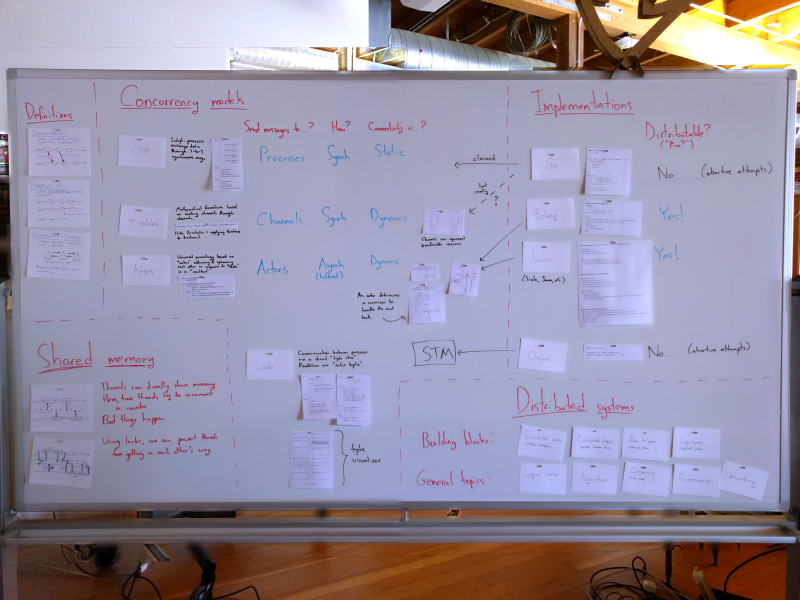

2016-04-06T18_11_56.166872.png

28.0841031075 seconds


In [40]:
with profile('big2.prof'):
    composite = cont_composite([canvas] + images, [operate(lambda a: np.ones_like(a) * 0.001, masks[0])] + masks)
    composite.show()

## double-close

In [41]:
xclose_arrays = map(cv2.imread, [
    'conc/2016-04-06 13.03.38.jpg',
    'conc/2016-04-06 13.03.43.jpg',
    'conc/2016-04-06 13.03.49.jpg',
    'conc/2016-04-06 13.03.56.jpg',
    'conc/2016-04-06 13.13.13.jpg',
])

xcloses = map(Image.from_array, xclose_arrays)

comp_features = find_features(composite.resize(composite.width / 3).astype(np.uint8))
xcs_features = [find_features(xc.resize(1200)) for xc in xcloses]
xhs = [find_homography(xc_features, comp_features) for xc_features in xcs_features]

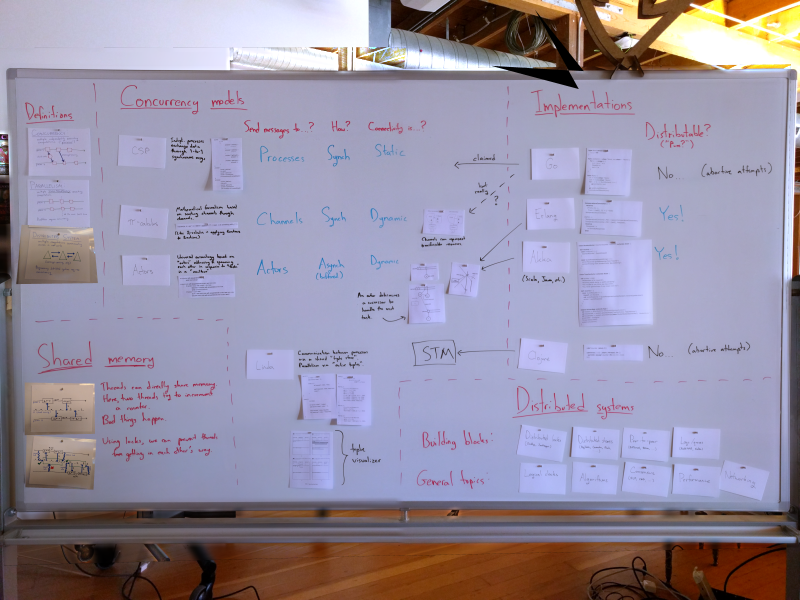

2016-04-06T18_12_34.079273.png

In [42]:
canvas = composite.copy()

for xclose, xh in zip(xcloses, xhs):
    canvas = apply_homography_onto(xclose, xh, canvas)

canvas.show()

In [47]:
edge_blur = 33
detail_blur = 33
erode = 33
canvas = composite.copy()
canvas_blurred = canvas.pipe(cv2.blur, (2 * detail_blur + 1, 2 * detail_blur + 1))

ximages = []
xmasks = []

todo = range(len(xcloses))

last = None

with profile('big1.prof'):
    for i in todo:
        import sys
        print i, len(todo), time.time() - last if last else ''
        last = time.time()
        sys.stdout.flush()
        foreground, homography_mask = apply_homography(
            white_balance(xcloses[i]).normalize(), xhs[i], canvas.system, canvas.dims, erode=1)
        combo_mask = (
            homography_mask
            .pipe(cv2.erode, np.ones((5, 5)))
            .pipe(cv2.blur, (edge_blur, edge_blur))
        )

        combo_image = detail_transfer(canvas, foreground, size=detail_blur, background_blurred=canvas_blurred, mask=homography_mask)
        
        ximages.append(combo_image)
        xmasks.append(combo_mask)

0 5 
1 5 6.35996413231
2 5 5.67677903175
3 5 5.73275208473
4 5 5.59226107597
29.1467211246 seconds


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide


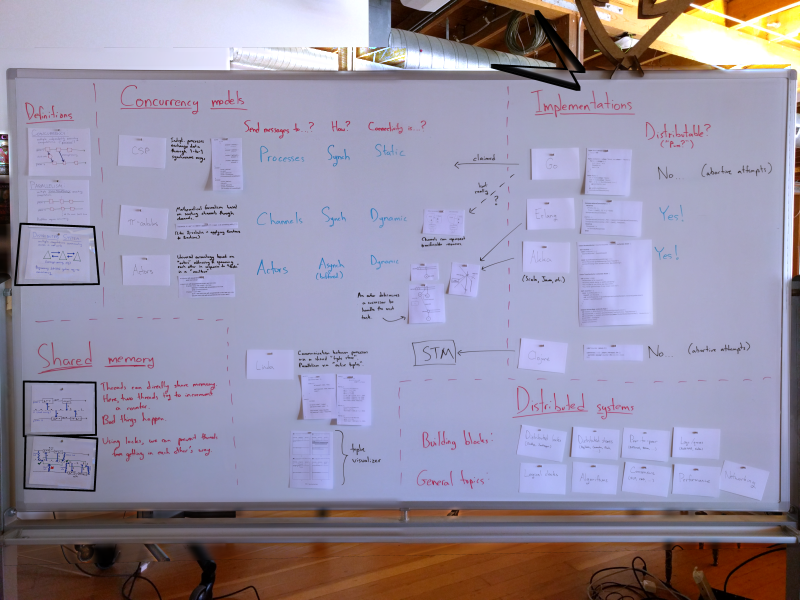

2016-04-06T18_36_20.378655.png

40.3532059193 seconds


In [50]:
with profile('big2.prof'):
    xcomposite = cont_composite([composite] + ximages, [operate(lambda a: np.ones_like(a) * 0.001, xmasks[0])] + xmasks)
    xcomposite.show()

## fancy stitch

In [ ]:
def detail_transfer(background, foreground, size=99, background_blurred=None):
    foreground_blurred = foreground.pipe(cv2.GaussianBlur, (2 * size + 1, 2 * size + 1), size)

    detail = operate(
        lambda num, denom: num / denom, 
        foreground.astype(float).pipe(lambda a: a + 4),
        foreground_blurred.astype(float).pipe(lambda a: a + 4)
    )

    if background_blurred is None:
        background_blurred = background.pipe(cv2.GaussianBlur, (2 * size + 1, 2 * size + 1), size)

    return operate(
        lambda a, b: a * b,
        background_blurred, detail
    )

canvas = establishing.resize(establishing.width * 3)
size = 99
canvas_blurred = canvas.pipe(cv2.GaussianBlur, (2 * size + 1, 2 * size + 1), size)

for i in [0, 2]:
    foreground, mask = apply_homography(closes[i], hs[i], canvas.system, canvas.dims)
    voronoi_mask = (
        canvas.pipe(np.zeros_like)
        .fill_poly(clip(facets[i], canvas.corners()), color=(1, 0, 0))
        .pipe(lambda x: x[:, :, 0])
    )
    combo_mask = operate(lambda x, y: x * y, mask, voronoi_mask)
    foreground_transferred = detail_transfer(canvas, foreground, background_blurred=canvas_blurred)
    composite(canvas, foreground_transferred, combo_mask, inplace=True)

# for (left, right) in h.inlier_matches:
#     # TODO: left and right are messed up
#     pt1 = hs[0](cs_features[0][right].point)
#     pt2 = hs[2](cs_features[2][left].point)
#     canvas.draw_line(pt1, pt2, width=1, inplace=True)

canvas.show()

In [ ]:
canvas = establishing.resize(establishing.width * 3)

def combo_mask(i):
    mask = homography_mask(closes[i].system, closes[i].dims, hs[i], canvas.system, canvas.dims)
    voronoi_mask = canvas.pipe(np.zeros_like).fill_poly(clip(facets[i], canvas.corners()), color=(1, 0, 0)).pipe(lambda x: x[:, :, 0])
    return operate(lambda x, y: x * y, mask, voronoi_mask)

cm0 = combo_mask(0)
cm2 = combo_mask(2)

In [ ]:
from operator import mul

size = 200
b0 = cm0.pipe(cv2.blur, (2 * size + 1, 2 * size + 1))
b2 = cm2.pipe(cv2.blur, (2 * size + 1, 2 * size + 1))
operate(mul, b0, b2).show()

# "bundle adjustment"

Todo:
* Smooth compositing:
  * blurring?
  * white-balance?
* Improve alignment:
  * close-to-close adjustment?
  * prioritization of points near seams?

In [ ]:
canvas = e.copy()
counts = np.bincount(sum((list(zip(*h.inlier_matches)[1]) for h in hs), []))
for i, f in enumerate(e_features):
    if i < len(counts):
        radius = counts[i] + 0
    else:
        radius = 0
    if radius > 0:
        canvas.draw_circle(f.point, radius=radius, inplace=True)
canvas.show()

In [ ]:
zip(*hs[0].inlier_matches)[1]

In [ ]:
e_relevant_oindices = np.unique(sum((list(zip(*h.inlier_matches)[1]) for h in hs), []))

In [ ]:
zip(*hs[0].inlier_matches)[0]

In [ ]:
c = np.array([[1, 2], [11, 12], [13, 14]])
indices = np.array([[0, 1], [1, 2], [0, 1]])

In [ ]:
((c[indices][:, 0] - c[indices][:, 1])**2).sum()

In [ ]:
list(np.array([[1, 2], [3, 4]]))

In [ ]:
from numba import jit

In [ ]:
@jit
def f(x, y):
    return x + y

f(3, 2)

In [ ]:
mindexed_coords = np.array([[1, 2], [11, 42], [-13, 22]])
pairs_of_mindices = np.array([[1, 2], [2, 0], [1, 0]])
pair_weights = np.array([[1], [2], [4]])

def sub_objective_1(mindexed_coords, pairs_of_mindices, pair_weights):
    paired_coords = mindexed_coords[pairs_of_mindices]
    return (pair_weights * (paired_coords[:, 0] - paired_coords[:, 1])).flatten()

@jit
def sub_objective_2(mindexed_coords, pairs_of_mindices, pair_weights):
    left_coords = mindexed_coords[pairs_of_mindices[:, 0]]
    right_coords = mindexed_coords[pairs_of_mindices[:, 1]]
    return (pair_weights * (left_coords - right_coords)).flatten()

print sub_objective_1(mindexed_coords, pairs_of_mindices, pair_weights)
print sub_objective_2(mindexed_coords, pairs_of_mindices, pair_weights)

In [ ]:
len(np.unique(np.array(hs[0].inlier_matches)[:, 0]))

In [ ]:
len(np.array(hs[0].inlier_matches)[:, 0])

In [ ]:
import scipy.optimize

# Unpacked format: list of N 3x3 arrays
# Packed format: (N*8) array
#   ()"in_rows" format: Nx8 array)

def pack_homographies(unpacked):
    in_rows = np.array([h.reshape(9)[:8] for h in unpacked])
    return in_rows.reshape((-1,))

def unpack_homographies(packed):
    in_rows = packed.reshape((-1, 8))
    return [np.append(row, 1).reshape((3, 3)) for row in in_rows]




from collections import defaultdict

# Input!
#   e_features: [feature, feature, ...] <- eoindexed
#   cs_features: [[feature, feature, ]... <- coindexed, ...] <- cindexed
#   hs[cindex].inlier_matches: [(coindex, eoindex), ...] <- cnindexed

# Produced!
#   e_ncoords: [coord, coord, ...] <- enindexed
#   cs_ncoords: [[coord, coord, ...] <- cnindexed, ...] <- cindexed
#   mcoords: [coord, coord, coord, coord, ...] <- mindexed (enindexes, then all the cnindexes)


# So we have the following meanings for integers:
#   eoindex
#   coindex
#   cindex
#   enindex
#   cnindex
#   mindex

# @jit
# def sub_objective(mindexed_coords, pairs_of_mindices, pair_weights):
#     left_coords = mindexed_coords[pairs_of_mindices[:, 0]]
#     right_coords = mindexed_coords[pairs_of_mindices[:, 1]]
#     return (pair_weights * (left_coords - right_coords)).flatten()

# Given a bunch of homographies from close-up images to an establishing image, improves them using
# information from close-up-to-close-up correspondences. Returns a new list of homographies.
def adjust_homographies(e_features, cs_features, hs):
    dst_system = hs[0].dst_system
    assert all(h.dst_system == dst_system for h in hs)
    
    # To populate:
    pairs_of_mindices_list = []  # list of (mindex, mindex) pairs
    pair_weights_list = []  # list of weights, cooresponding to ^
    cs_relevant_coords = []  # cindexed list of c_nindexed coords

    # First, process e:
    e_oindices = np.unique(sum((list(zip(*h.inlier_matches)[1]) for h in hs), []))
    e_oindex_to_nindex = dict((v, k) for (k, v) in enumerate(e_oindices))
    e_ncoords = np.array([e_features[i].point.in_system(dst_system).coords for i in e_oindices])
    
    # Next, process each c:
    m_coord_offset = len(e_ncoords)
    for c_index, (c_features, h) in enumerate(zip(cs_features, hs)):
        src_system = h.src_system
        matches = h.inlier_matches  # list of (c_oindex, e_oindex) pairs
        cs_relevant_coords.append([c_features[c_oindex].point.in_system(src_system).coords for c_oindex, e_oindex in matches])
        for c_nindex, (c_oindex, e_oindex) in enumerate(matches):
            pairs_of_mindices_list.append([m_coord_offset + c_nindex, e_oindex_to_nindex[e_oindex]])
            pair_weights_list.append(1)
        # TODO: pairs of closes!
        m_coord_offset += len(matches)
        print len(matches)
    num_mindices = m_coord_offset
    print num_mindices

    pairs_of_mindices = np.array(pairs_of_mindices_list)
    pair_weights = np.array([pair_weights_list]).T
    
    mindexed_coords = np.resize(e_ncoords, (num_mindices, 2))
    
    # Each homography is provided as a vector of 8 numbers, to be reshaped
    # so `homographies` is an Nx8 array
    def objective(homographies):
        homographies = unpack_homographies(homographies)
        m_coord_offset = len(e_ncoords)
        for i, coords in enumerate(cs_relevant_coords):
            transformed_coords = cv2.perspectiveTransform(np.array([coords], dtype='float64'), homographies[i])[0]
            mindexed_coords[m_coord_offset:m_coord_offset+len(transformed_coords)] = transformed_coords
            m_coord_offset += len(matches)
        left_coords = mindexed_coords[pairs_of_mindices[:, 0]]
        right_coords = mindexed_coords[pairs_of_mindices[:, 1]]
        return (pair_weights * (left_coords - right_coords)).flatten()

#         return sub_objective(mindexed_coords, pairs_of_mindices, pair_weights)
#         result = np.sum(pair_weights * (paired_coords[:, 0] - paired_coords[:, 1])**2)
#         return result
    global checkit
    checkit = objective

    starting_homographies = pack_homographies([h.matrix for h in hs])
#     print objective(starting_homographies)
#     for i in range(10):
#         print objective(starting_homographies + (np.random.rand(*starting_homographies.shape) - 0.5) / 1000)
#     return scipy.optimize.minimize(objective, starting_homographies, method='Nelder-Mead')
    starting_homographies_noise = starting_homographies + (np.random.rand(*starting_homographies.shape) - 0.5) / 1000
    print starting_homographies
    print starting_homographies_noise
    result = scipy.optimize.leastsq(objective, starting_homographies_noise, full_output=True)
    print list(result[0] - starting_homographies)
    return result
    
result = adjust_homographies(e_features, cs_features[:2], hs[:2])

In [ ]:
from pprint import pprint

def pack_homography_matrices(unpacked):
    in_rows = np.array([h.reshape(9)[:8] for h in unpacked])
    return in_rows.reshape((-1,))

def unpack_homography_matrices(packed):
    in_rows = packed.reshape((-1, 8))
    return [np.append(row, 1).reshape((3, 3)) for row in in_rows]

def adjust_homographies_raw(e_points, cs_points, matrices, inlier_match_lists):
    # To populate:
    pairs_of_mindices_list = []  # list of (mindex, mindex) pairs
    pair_weights_list = []  # list of weights, cooresponding to ^
    cs_relevant_coords = []  # cindexed list of c_nindexed coords

    # First, process e:
    e_oindices = np.unique(sum((list(zip(*inlier_match_list)[1]) for inlier_match_list in inlier_match_lists), []))
    global e_oindex_to_nindex
    e_oindex_to_nindex = dict((v, k) for (k, v) in enumerate(e_oindices))
    e_ncoords = np.array([e_points[i] for i in e_oindices])
    
    # Next, process each c:
    mindex_offset = len(e_ncoords)
    global mindices_mapping_to_e_nindex
    mindices_mapping_to_e_nindex = defaultdict(list)
    for c_points, inlier_match_list in zip(cs_points, inlier_match_lists):
        cs_relevant_coords.append([c_points[c_oindex] for c_oindex, e_oindex in inlier_match_list])
        for c_nindex, (c_oindex, e_oindex) in enumerate(inlier_match_list):
            e_nindex = e_oindex_to_nindex[e_oindex]
            mindex = mindex_offset + c_nindex
            pairs_of_mindices_list.append([mindex, e_nindex])
            pair_weights_list.append(1)

            previous_mindices = mindices_mapping_to_e_nindex[e_nindex]
            for prev_mindex in previous_mindices:
#                 print [e_nindex, e_oindices[e_nindex], mindex, prev_mindex]
                pairs_of_mindices_list.append([mindex, prev_mindex])
                pair_weights_list.append(200)

            mindices_mapping_to_e_nindex[e_nindex].append(mindex)

        mindex_offset += len(inlier_match_list)
    num_mindices = mindex_offset

    pairs_of_mindices = np.array(pairs_of_mindices_list)
    pair_weights = np.array([pair_weights_list]).T
    
    mindexed_coords = np.resize(e_ncoords, (num_mindices, 2))
    
    # Each homography is provided as a vector of 8 numbers, to be reshaped
    # so `homographies` is an Nx8 array
    def objective(vector):
        matrices = unpack_homography_matrices(vector)
        mindex_offset = len(e_ncoords)
        for coords, matrix in zip(cs_relevant_coords, matrices):
            transformed_coords = cv2.perspectiveTransform(np.array([coords], dtype='float64'), matrix)[0]
            mindexed_coords[mindex_offset:mindex_offset+len(transformed_coords)] = transformed_coords
            mindex_offset += len(transformed_coords)
        left_coords = mindexed_coords[pairs_of_mindices[:, 0]]
        right_coords = mindexed_coords[pairs_of_mindices[:, 1]]
        return (pair_weights * (left_coords - right_coords)).flatten()

    starting_vector = pack_homography_matrices(matrices)
    starting_vector_noise = starting_vector # + (np.random.rand(*starting_vector.shape) - 0.5) / 1000
    print starting_vector
    print starting_vector_noise
    result = scipy.optimize.leastsq(objective, starting_vector_noise, full_output=True)
    print result[0]
    print pprint(unpack_homography_matrices(result[0] - starting_vector))
    return result

np.set_printoptions(suppress=True)

e_points = np.array([f.point.in_system(hs[0].dst_system).coords for f in e_features])
cs_points = [
    np.array([f.point.in_system(h.src_system).coords for f in c_features])
    for c_features, h in zip(cs_features, hs)
]
matrices = [h.matrix for h in hs]
inlier_match_lists = [h.inlier_matches for h in hs]

result = adjust_homographies_raw(e_points, cs_points[:3], matrices[:3], inlier_match_lists[:3])

# def external_objective(e_coords, c_coords, h, matches):
#     transformed = cv2.perspectiveTransform(np.array([c_coords], dtype='float64'), h)[0]
#     left = transformed[np.array(matches)[:, 0]]
#     right = np.array(e_coords)[np.array(matches)[:, 1]]
#     return np.sum((left - right) ** 2)

# for i in range(0, 2):

#     print external_objective(
#         [f.point.in_system(hs[0].dst_system).coords for f in e_features],
#         [f.point.in_system(hs[i].src_system).coords for f in cs_features[i]],
#         hs[i].matrix,
#         hs[i].inlier_matches
#     )

#     print external_objective(
#         [f.point.in_system(hs[0].dst_system).coords for f in e_features],
#         [f.point.in_system(hs[i].src_system).coords for f in cs_features[i]],
#         unpack_homographies(result[0])[i],
#         hs[i].inlier_matches
#     )

# print result[3]

In [ ]:
dict(mindices_mapping_to_e_nindex)

In [ ]:
s0 = set(b for a, b in hs[0].inlier_matches)
s2 = set(b for a, b in hs[2].inlier_matches)

In [ ]:
sorted([e_oindex_to_nindex[i] for i in s0 & s2])

In [ ]:
result = adjust_homographies(e_features, cs_features[:1], hs[:1])
print np.sum(checkit(pack_homographies([h.matrix for h in hs])) ** 2)
print np.sum(checkit(result[0]) ** 2)

In [ ]:
packed = result[0]
# packed = pack_homographies([h.matrix for h in hs])
new_homography = Homography(hs[0].src_system, hs[0].dst_system, unpack_homographies(packed)[0])
apply_homography_onto(closes[0], new_homography, establishing).show()

In [ ]:
canvas = establishing.resize(establishing.width * 3)

for i in [0, 2]:
    foreground, mask = apply_homography(closes[i], hs[i], canvas.system, canvas.dims)
    voronoi_mask = (
        canvas.pipe(np.zeros_like)
        .fill_poly(clip(facets[i], canvas.corners()), color=(1, 0, 0))
        .pipe(lambda x: x[:, :, 0])
    )
    combo_mask = operate(lambda x, y: x * y, mask, voronoi_mask)
#     foreground_transferred = detail_transfer(canvas, foreground, background_blurred=canvas_blurred)
    composite(canvas, foreground, combo_mask, inplace=True)

canvas.show()

In [ ]:
new_matrices = unpack_homography_matrices(result[0])

canvas = establishing.resize(establishing.width * 3)

for i in [0, 2]:
    new_homography = Homography(hs[i].src_system, hs[i].dst_system, new_matrices[i])
    foreground, mask = apply_homography(closes[i], new_homography, canvas.system, canvas.dims)
    voronoi_mask = (
        canvas.pipe(np.zeros_like)
        .fill_poly(clip(facets[i], canvas.corners()), color=(1, 0, 0))
        .pipe(lambda x: x[:, :, 0])
    )
    combo_mask = operate(lambda x, y: x * y, mask, voronoi_mask)
#     foreground_transferred = detail_transfer(canvas, foreground, background_blurred=canvas_blurred)
    composite(canvas, foreground, combo_mask, inplace=True)

canvas.show()

# other stuff

In [ ]:
# # Drawing features from cs onto a copy of c: effortless!
# im = c.copy()
# for f in c_features:
#     im.draw_circle(f.point, 10, inplace=True)
# im.show()

# better illumination correction

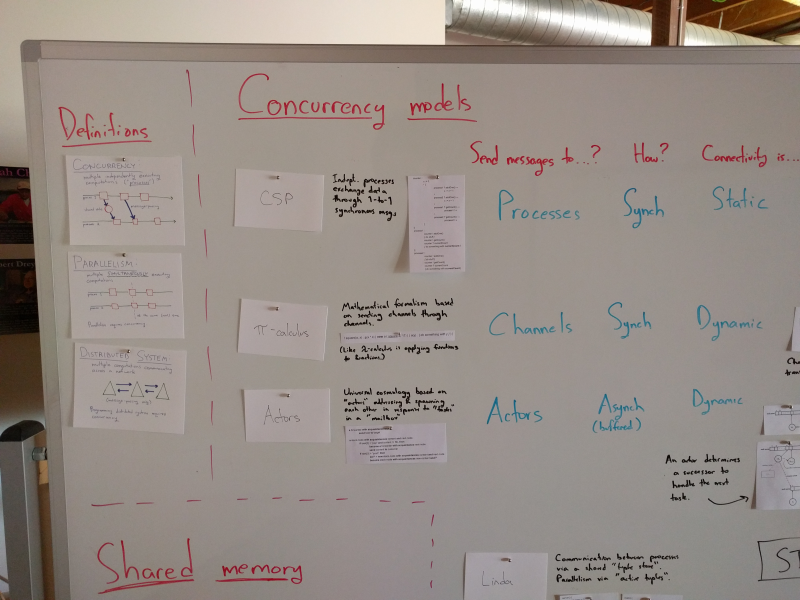

2016-04-06T18_43_02.652647.png

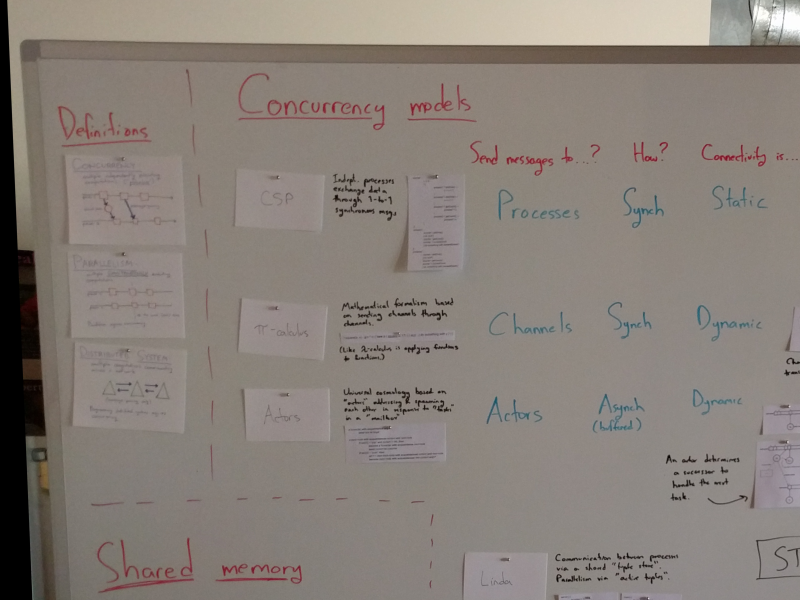

2016-04-06T18_43_03.306774.png

In [58]:
d, _ = apply_homography(establishing, hs[0].invert(), closes[0].system, closes[0].dims)

closes[0].show()
d.show()

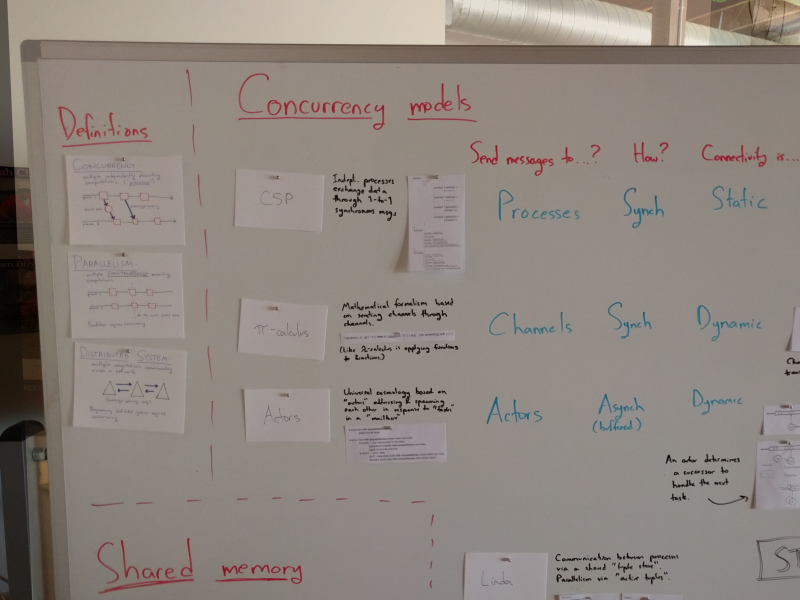

2016-04-06T18_43_26.496319.png

In [59]:
operate(lambda a, b: a/2 + b/2, closes[0], d).show()